# Comparing the PE results from two models (Perspective API of two versions)

In [1]:
import sys
from os.path import dirname, abspath

sys.path.append(dirname(abspath('')))

In [30]:
import json, re
import pandas as pd
from collections import Counter

from pyquantifier.data import Dataset
from pyquantifier.distributions import BinnedCUD, ExtrinsicJointDistribution


In [3]:
def get_majority_vote(lst):
    return Counter(lst).most_common(1)[0][0]

In [4]:
all_labels = ['pos', 'neg']
label_data_filepath = 'labeled_hot_data_202108.json'
base_period_filepath = '202108_base_hot_comments.json'

In [5]:
uid_list = []
platform_list = []
model1_pos_list = []
model1_neg_list = []
model2_pos_list = []
model2_neg_list = []
hot_label_list = []
uid = 0

label_map = {True: 'pos', False: 'neg'}
with open(label_data_filepath, 'r') as fin:
    for line in fin:
        comment_json = json.loads(line.rstrip())
        platform = comment_json['platform']
        toxicity_score1 = comment_json['toxicity']
        toxicity_score2 = comment_json['toxicity_0319']
        hot_label = label_map[get_majority_vote([(x[0] | y[0] | z[0]) for x, y, z 
                                                    in zip(comment_json['composite_hate'], comment_json['composite_offensive'], comment_json['composite_toxic'])])]

        uid += 1
        uid_list.append(uid)
        platform_list.append(platform)
        model1_pos_list.append(toxicity_score1)
        model1_neg_list.append(1-toxicity_score1)
        model2_pos_list.append(toxicity_score2)
        model2_neg_list.append(1-toxicity_score2)
        hot_label_list.append(hot_label)

model1_df = pd.DataFrame.from_dict({'uid': uid_list, 'platform': platform_list, 'pos': model1_pos_list, 'neg': model1_neg_list, 'gt_label': hot_label_list})
model2_df = pd.DataFrame.from_dict({'uid': uid_list, 'platform': platform_list, 'pos': model2_pos_list, 'neg': model2_neg_list, 'gt_label': hot_label_list})

model_dict = {}
for platform in ['reddit', 'twitter', 'youtube']:
    # obtain the calibration curves for different platforms and different models
    model_dict[f'{platform}_model1'] = Dataset(df=model1_df[model1_df.platform == platform], labels=all_labels)
    model_dict[f'{platform}_model1'].update_calibration_curve(method='platt scaling')
    model_dict[f'{platform}_model2'] = Dataset(df=model2_df[model2_df.platform == platform], labels=all_labels)
    model_dict[f'{platform}_model2'].update_calibration_curve(method='platt scaling')

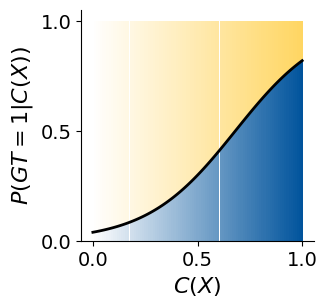

In [6]:
model_dict['reddit_model1'].calibration_curve.plot()

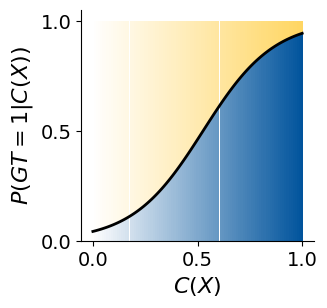

In [7]:
model_dict['reddit_model2'].calibration_curve.plot()

In [8]:
reddit_model1_toxicity_list = []
reddit_model2_toxicity_list = []
twitter_model1_toxicity_list = []
twitter_model2_toxicity_list = []
youtube_model1_toxicity_list = []
youtube_model2_toxicity_list = []

with open(base_period_filepath, 'r') as fin:
    for line in fin:
        article_json = json.loads(line.rstrip())
        reported_rd_comments = article_json['reported_rd_comments']
        reported_tw_replies = article_json['reported_tw_replies']
        reported_yt_comments = article_json['reported_yt_comments']

        reddit_model1_toxicity_list.extend([x['toxicity'] for x in reported_rd_comments if isinstance(x['toxicity'], float)])
        reddit_model2_toxicity_list.extend([x['toxicity_0216'] for x in reported_rd_comments if isinstance(x['toxicity_0216'], float)])
        twitter_model1_toxicity_list.extend([x['toxicity'] for x in reported_tw_replies if isinstance(x['toxicity'], float)])
        twitter_model2_toxicity_list.extend([x['toxicity_0216'] for x in reported_tw_replies if isinstance(x['toxicity_0216'], float)])
        youtube_model1_toxicity_list.extend([x['toxicity'] for x in reported_yt_comments if isinstance(x['toxicity'], float)])
        youtube_model2_toxicity_list.extend([x['toxicity_0216'] for x in reported_yt_comments if isinstance(x['toxicity_0216'], float)])

In [9]:
len(reddit_model1_toxicity_list)

145843

In [10]:
classifier_score_density_dict = {}
for platform in ['reddit', 'twitter', 'youtube']:
    # obtain the classifier score density for different platforms and different models
    classifier_score_density_dict[f'{platform}_model1'] = BinnedCUD(data=reddit_model1_toxicity_list, num_bin=20)
    classifier_score_density_dict[f'{platform}_model2'] = BinnedCUD(data=reddit_model2_toxicity_list, num_bin=20)

## Reddit

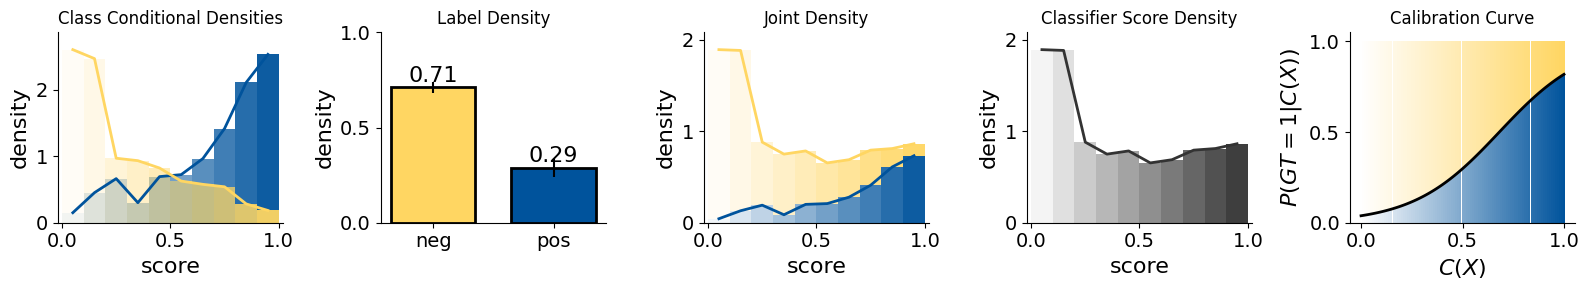

In [11]:
model_dict['reddit_model1'].profile_dataset()

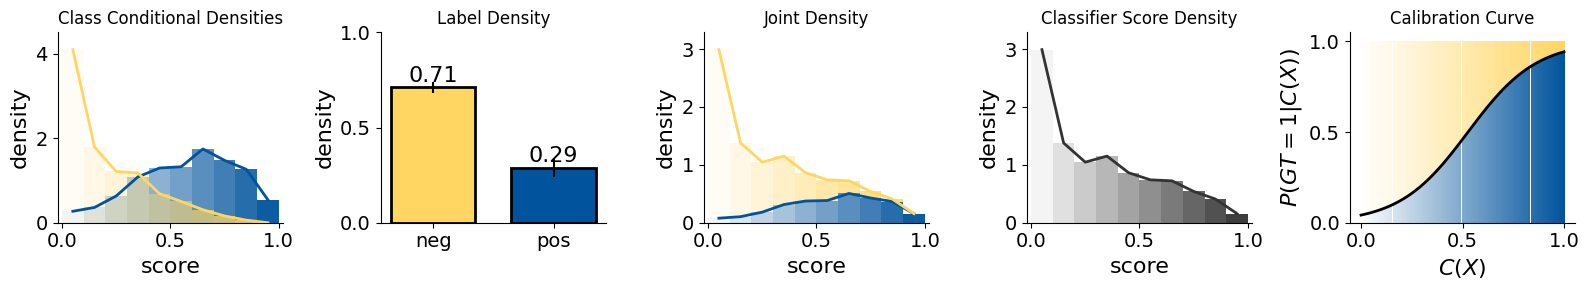

In [12]:
model_dict['reddit_model2'].profile_dataset()

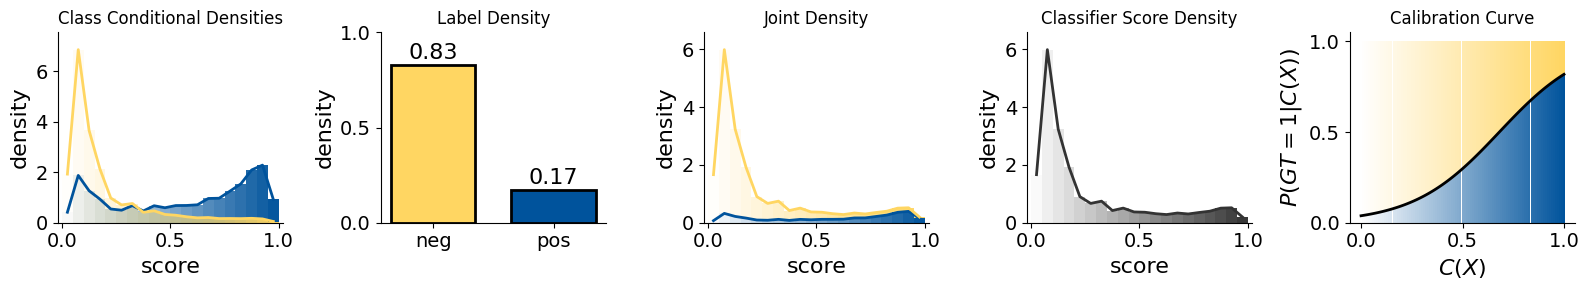

In [13]:
reddit_model1_jd = ExtrinsicJointDistribution(all_labels, classifier_score_density_dict['reddit_model1'], model_dict['reddit_model1'].calibration_curve)
reddit_model1_jd.plot_five_distributions()

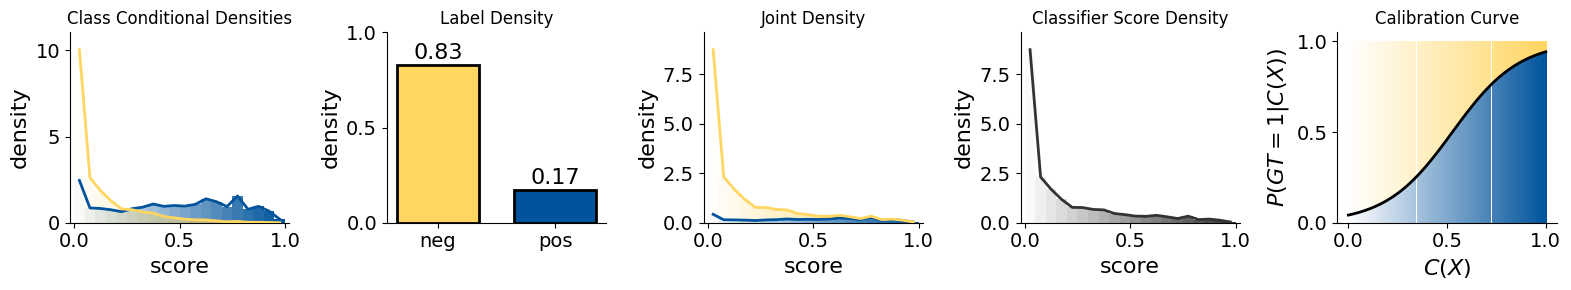

In [14]:
reddit_model2_jd = ExtrinsicJointDistribution(all_labels, classifier_score_density_dict['reddit_model2'], model_dict['reddit_model2'].calibration_curve)
reddit_model2_jd.plot_five_distributions()

## Twitter

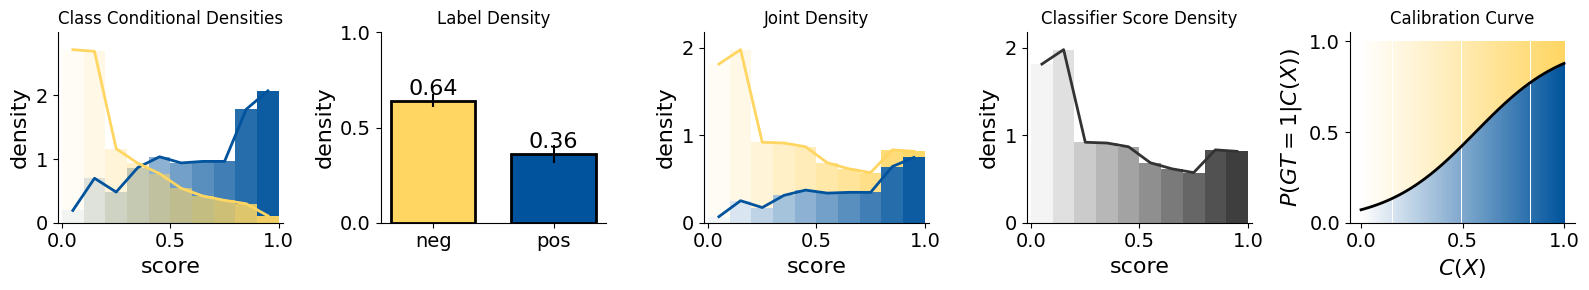

In [15]:
model_dict['twitter_model1'].profile_dataset()

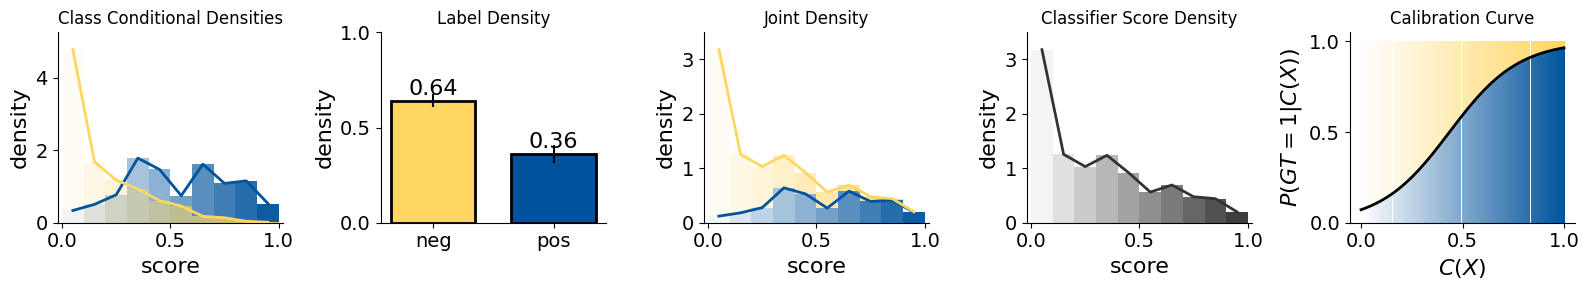

In [16]:
model_dict['twitter_model2'].profile_dataset()

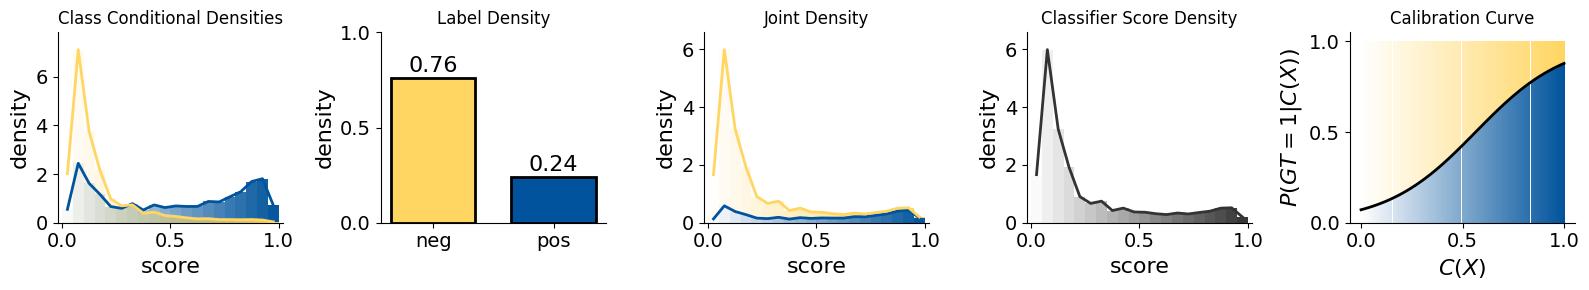

In [17]:
twitter_model1_jd = ExtrinsicJointDistribution(all_labels, classifier_score_density_dict['twitter_model1'], model_dict['twitter_model1'].calibration_curve)
twitter_model1_jd.plot_five_distributions()

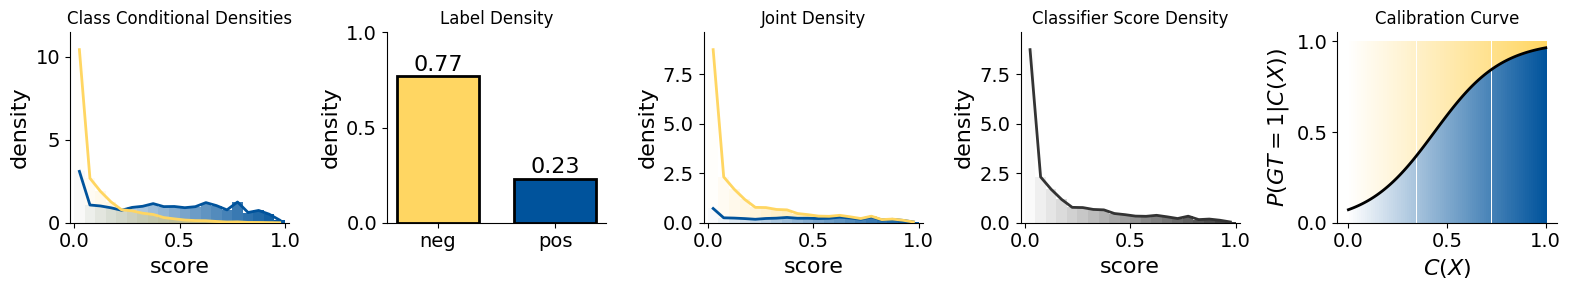

In [18]:
twitter_model2_jd = ExtrinsicJointDistribution(all_labels, classifier_score_density_dict['twitter_model2'], model_dict['twitter_model2'].calibration_curve)
twitter_model2_jd.plot_five_distributions()

## YouTube

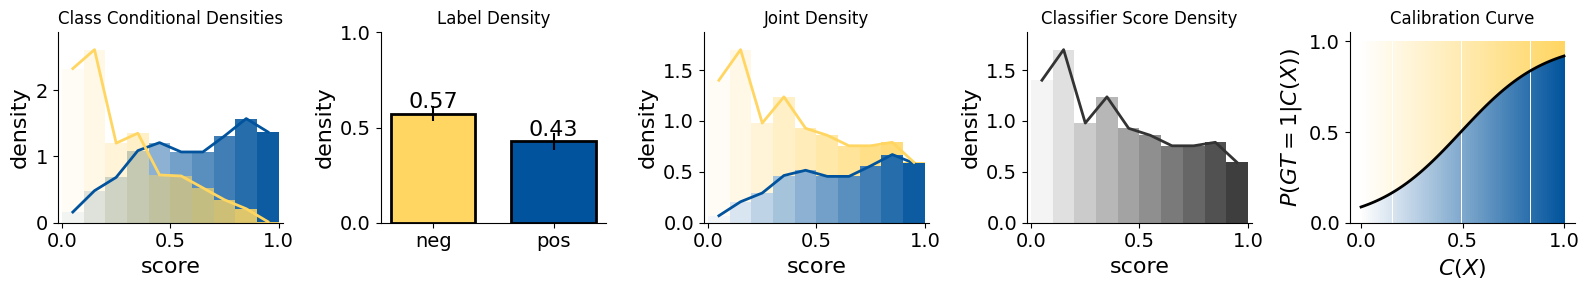

In [19]:
model_dict['youtube_model1'].profile_dataset()

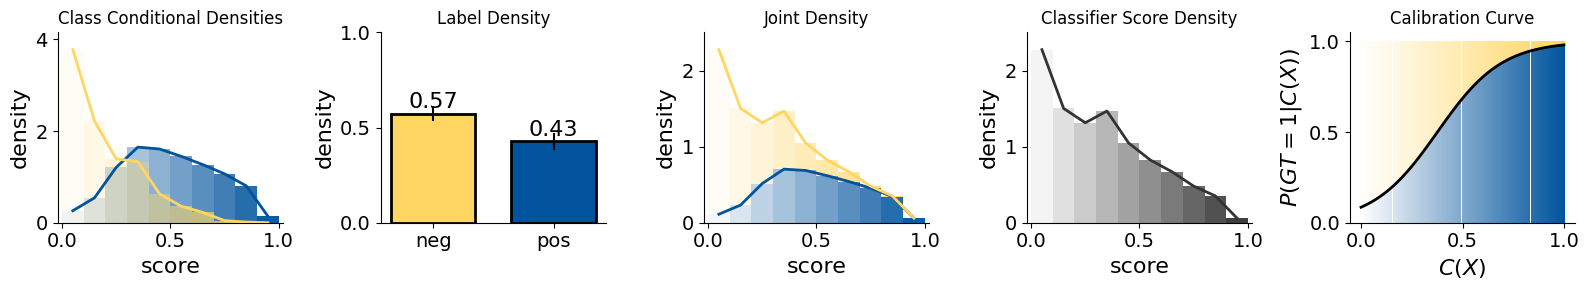

In [20]:
model_dict['youtube_model2'].profile_dataset()

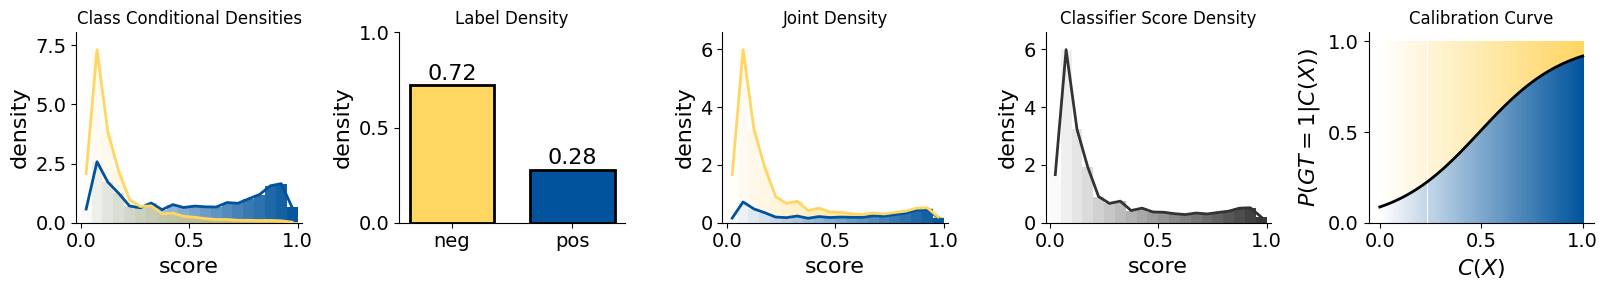

In [21]:
youtube_model1_jd = ExtrinsicJointDistribution(all_labels, classifier_score_density_dict['youtube_model1'], model_dict['youtube_model1'].calibration_curve)
youtube_model1_jd.plot_five_distributions()

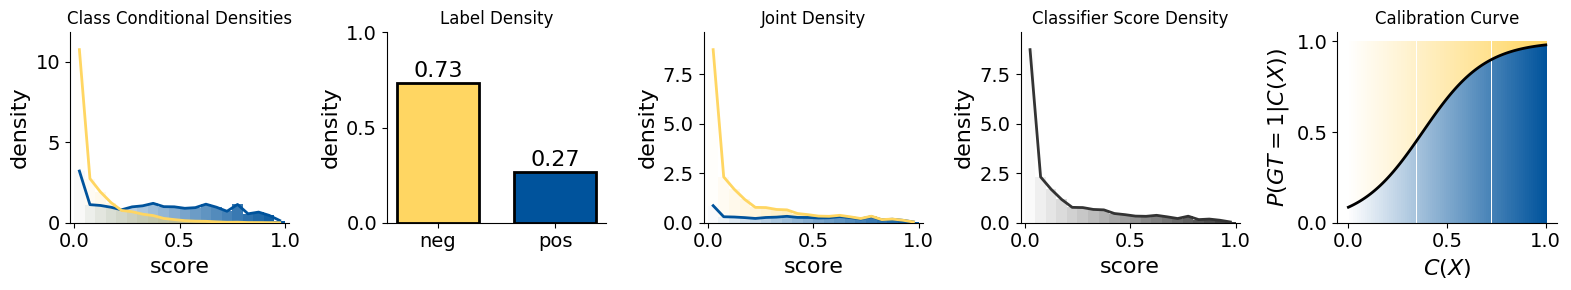

In [22]:
youtube_model2_jd = ExtrinsicJointDistribution(all_labels, classifier_score_density_dict['youtube_model2'], model_dict['youtube_model2'].calibration_curve)
youtube_model2_jd.plot_five_distributions()

## Validate Perspective API scores across different periods

In [39]:
def preprocess(text_string, is_reddit):
    """Accepts a text string and replaces:
    1) lots of whitespace with one instance
    2) remove urls
    3) remove mentions
    4) remove quoted text on Reddit
    5) skip removed, deleted, bot comments on Reddit

    This allows us to get standardized counts of urls and mentions.
    Without caring about specific people mentioned.
    """
    if is_reddit:
        if text_string == '[removed]' or text_string == '[deleted]' \
                or 'I am a bot' in text_string or "I'm a bot" in text_string:
            return ''
        # reddit_quote_regex = r'>[\w\-\s]+(\n)\1'
        reddit_quote_regex = r'^>.*\n$'
        text_string = re.sub(reddit_quote_regex, ' ', text_string)

    space_pattern = r'\s+'
    text_string = re.sub(space_pattern, ' ', text_string)

    giant_url_regex = (r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
                       r'[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text_string = re.sub(giant_url_regex, ' ', text_string)

    mention_regex = r'@[\w\-]+'
    text_string = re.sub(mention_regex, ' ', text_string)
    return text_string.strip()

In [46]:
giant_url_regex = (r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
                   r'[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
mention_regex = r'@[\w\-]+'

num_all_match = 0
num_all_match_url_mention = 0
num_all_match_no_url_mention = 0

num_mismatch = 0
num_mismatch_url_mention = 0
num_mismatch_no_url_mention = 0

num_mismatch_mar_oct = 0
with open('new_20221217_classified_hot_comments.json', 'r') as fin:
    for line in fin:
        url_json = json.loads(line.rstrip())
        for field in ['selected_reddit_comments',
                      'selected_twitter_replies',
                      'selected_youtube_comments']:
            selected_comments = url_json[field]
            for comment_obj in selected_comments:
                toxicity1 = comment_obj['toxicity']
                toxicity2 = comment_obj['toxicity_0319']
                toxicity3 = comment_obj['toxicity_1011']
                text = comment_obj['text']

                if toxicity3 != 'em' and toxicity3 != 'INVALID_ARGUMENT':
                    if toxicity1 == toxicity2 == toxicity3:
                        # print('all match!')
                        num_all_match += 1
                        if re.search(giant_url_regex, text) or re.search(mention_regex, text):
                            # print('url or mention found!')
                            num_all_match_url_mention += 1
                        else:
                            num_all_match_no_url_mention += 1
                    else:
                        print(f'{toxicity1} -> {toxicity2} -> {toxicity3}')
                        num_mismatch += 1
                        if re.search(giant_url_regex, text) or re.search(mention_regex, text):
                            # print('url or mention found!')
                            num_mismatch_url_mention += 1
                        else:
                            num_mismatch_no_url_mention += 1
                            print(text)
                            print('-' * 79)
                        # print(re.search(giant_url_regex, text))
                        # print(re.search(mention_regex, text))
                        # print('-'*79)
                        if toxicity2 != toxicity3:
                            num_mismatch_mar_oct += 1

print(f'{num_all_match} all match, {num_mismatch} mismatch')
print(f'in all match, {num_all_match_url_mention} has url or mention, {num_all_match_no_url_mention} has no url or mention')
print(f'in mismatch, {num_mismatch_url_mention} has url or mention, {num_mismatch_no_url_mention} has no url or mention')
print(f'{num_mismatch_mar_oct} mismatch between March and October')

0.006188785 -> 0.006942749 -> 0.006942749
Their Model X plaid is worth $165,000. 
My guess semi would be North of $300,000.
-------------------------------------------------------------------------------
0.019980038 -> 0.022139108 -> 0.022139108
Wonder how much beer was in with Anheuser?
Looked loaded in the “Biagi” Driver change video to me…
-------------------------------------------------------------------------------
0.013885498 -> 0.016021729 -> 0.016021729
And keeping the truck production between themselves and Pepsi orders…

Sounds like they may haven’t developed what they expected yet.
-------------------------------------------------------------------------------
0.024731753 -> 0.025910228 -> 0.025910228
That’s a bearish assumption.

They state clearly in the video they deliver for AB.
-------------------------------------------------------------------------------
0.05378982 -> 0.07212844 -> 0.07212844
Whether you are a Bull or Bear towards Nikola Corp., this sub welcomes logi

In [52]:
num_all_match = 0
num_mismatch = 0
with open('new_20230401_classified_hot_comments.json', 'r') as fin:
    for line in fin:
        url_json = json.loads(line.rstrip())
        for field in ['selected_reddit_comments',
                      'selected_twitter_replies',
                      'selected_youtube_comments']:
            selected_comments = url_json[field]
            for comment_obj in selected_comments:
                toxicity1 = comment_obj['toxicity']
                toxicity2 = comment_obj['toxicity_1011']
                text = comment_obj['text']

                if toxicity2 != 'em' and toxicity2 != 'INVALID_ARGUMENT':
                    if toxicity1 == toxicity2:
                        # print('all match!')
                        num_all_match += 1
                    else:
                        print(f'{toxicity1} -> {toxicity2}')
                        num_mismatch += 1
                        print(text)
                        print('+'*79)
                        print(preprocess(text, 'reddit' in field))
                        print('-'*79)


print(f'{num_all_match} all match, {num_mismatch} mismatch')

0.015142105 -> 0.020960633
> https://abc7chicago.com/apollo-theater-belvidere-il-collapse-tornado/13060700/

Even where I'm at, farther south and closer to the city, but still in the path of where this storm went - I was hearing about this as it was unfolding, and stepped outside for a second, and it was just like, kinda windy, and not even really raining yet.

Within less than 5 minutes, I was in my basement as trees and branches were falling down in my neighborhood.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
>   Even where I'm at, farther south and closer to the city, but still in the path of where this storm went - I was hearing about this as it was unfolding, and stepped outside for a second, and it was just like, kinda windy, and not even really raining yet. Within less than 5 minutes, I was in my basement as trees and branches were falling down in my neighborhood.
-------------------------------------------------------------------------------
